## Практическое задание № 6
1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете.
2. Опишите результат. Что помогло повысить точность?
3. *Попробуйте свои силы в задаче City Scapes на Kaggle - https://www.kaggle.com/dansbecker/cityscapes-image-pairs.
4. *Сделайте свою реализацию U-Net на TensorFlow

### Выбор набора данных

> В задании использованы работы Visual [Geometry Group](https://www.robots.ox.ac.uk/~vgg/).
> Для демонстрации работы сети V-Net используется набор [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
> Набор обладает следующими характеристиками:
> - Количество классов - 37
> - Количество изображений в классе - 200
> - Вариативность - масштаб, поза и освещение
> - Идентификация головы
> - Сегментация по контуру
> - Описание породы

### Загрузка данных

In [2]:
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

images.tar.gz - 0.77Г
annotations.tar.gz - 18М

### Подготовка данных соответствия файлов по папкам

In [21]:
import os

input_dir = "images/"
samples_dir = "samples/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [22]:
# картинка
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
# таргет - контур
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

# посторонние картинки из Интернет
samples_img_paths = sorted(
    [
        os.path.join(samples_dir, fname)
        for fname in os.listdir(samples_dir)
        if fname.endswith(".jpg")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


### Показ содержимого

In [23]:
from IPython.display import Image, display
from keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

In [41]:
def show_img(file1, file2=None):
    img = PIL.ImageOps.autocontrast(load_img(file1))
    display(img.resize((160,160)))
    if file2 is not None:
        img = PIL.ImageOps.autocontrast(load_img(file2))
        display(img.resize((160,160)))

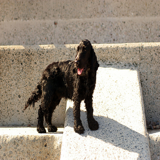

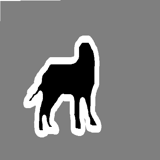

In [42]:
show_img(input_img_paths[9], target_img_paths[9])

### Класс работы с набором данных

In [26]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

### Создание U - модели

In [27]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [28]:

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### Разделение набора данных

In [29]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

### Обучение модели

In [26]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 760s 4s/step - loss: 0.9913 - val_loss: 1.8088
Epoch 2/15
199/199 [==============================] - 842s 4s/step - loss: 0.5130 - val_loss: 2.5205
Epoch 3/15
199/199 [==============================] - 765s 4s/step - loss: 0.4272 - val_loss: 0.4584
Epoch 4/15
199/199 [==============================] - 739s 4s/step - loss: 0.3819 - val_loss: 0.4087
Epoch 5/15
199/199 [==============================] - 762s 4s/step - loss: 0.3465 - val_loss: 0.4019
Epoch 6/15
  4/199 [..............................] - ETA: 11:15 - loss: 0.3245

KeyboardInterrupt: 

In [45]:
(760 + 842 + 765 + 739 + 762) / 60

64.46666666666667


#### Вывод:
> Обучение проводил как в колабе на GPU, так и на домашнем компьютере
> Приемлемые результаты получаются на 4 эпохе, дальнейшие обучение влияет только на тренировочный набор,
> потери на валидационном наборе увеличиваются - наступает переобучение
> Обучение на простом копьютере (Core i 7, 16Г) заняло около часа. Модель сохранена

In [ ]:
# model.save('my_oxford_model.keras')

### Загрузка модели

[загрузка модели из яндекс диска](https://disk.yandex.ru/d/Tl7zbGISa6uDvQ)

In [30]:
model = keras.models.load_model('my_oxford_model.keras')

### Визуальный контроль качества

In [46]:
# Generate predictions for all images in the validation set
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [47]:
def display_mask(mask_vect):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(mask_vect, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img.resize((160,160)))


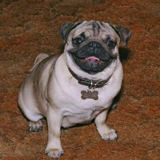

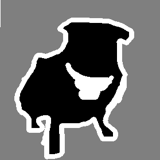

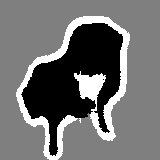

In [48]:
i=10
show_img(val_input_img_paths[i], val_target_img_paths[i])
# Display mask predicted by our model
display_mask(val_preds[i])  # Note that the model only sees inputs at 150x150.

### Распознание случайных картинок из Интернет

In [49]:
val_gen2 = OxfordPets(1, img_size, samples_img_paths, samples_img_paths)
val_preds2 = model.predict(val_gen2)

In [50]:
def display_mask2(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds2[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

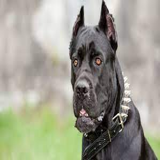

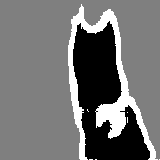

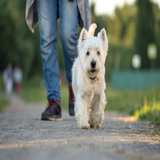

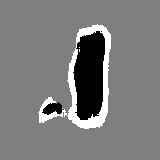

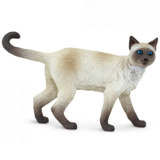

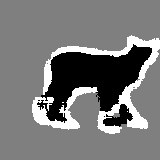

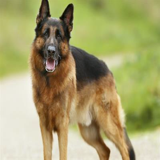

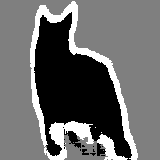

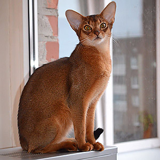

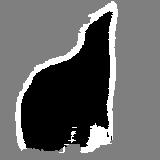

In [51]:
for i, img in enumerate(samples_img_paths):
    show_img(img)
    display_mask(val_preds2[i])

#### Вывод
> 1. Обученная модель дает хорошие результаты на изображениях из тестового набора,
> а также приемлемые результаты на случайных картинках из интернета
> 2. Обучение требует больших затрат и экономного использования ресурсов
> 3. В процессе обучения применен callback ModelCheckpoint для оперативного сохранения результатов работы обучения и переноса на эффективную платформу
> 4. Использован механизм инкапсуляции с помощью класса OxfordPets элементов набора для прозрачного предоставления в функцию модели.